In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

# Modeling

**Masked Convolution Layer**  

특징 분할: 입력된 각 픽셀의 h 특징은 R, G, B 세 가지 채널로 나뉜다.  


- R 채널 예측: 현재 픽셀 $x_i$의 R 값을 예측할 때는 $x_i$의 왼쪽과 위쪽에 있는 픽셀만을 사용할 수 있다.  
- G 채널 예측: G 값을 예측할 때는 R 채널의 이전 예측 값과 함께, 이전 생성된 픽셀을 사용할 수 있다.
- B 채널 예측: B 값을 예측할 때는 R 및 G 채널의 이전 예측 값이 모두 사용된다.
- 마스크 적용: 네트워크의 연결을 제약하기 위해 마스크를 사용한다.
    - 마스크 A: PixelRNN의 첫 번째 합성곱 층에만 적용되며, 현재 픽셀에서 이미 예측된 색상과 이웃 픽셀에 대한 연결만 허용한다.
    - 마스크 B: 모든 후속 입력-상태 합성곱 전이에서 적용되며, 마스크 A의 제한을 완화하여 색상이 자기 자신과 연결될 수 있도록 허용한다.

- 가중치 제로화: 마스크는 각 업데이트 후 입력-상태 합성곱에서 해당하는 가중치를 0으로 설정하여 쉽게 구현할 수 있다.

In [2]:
class MaskedConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, mask_type='A', device='cpu'):
        super(MaskedConvLayer, self).__init__()

        assert mask_type in ['A', 'B'], f'mask_type is wrong!! {mask_type}'

        self.mask_type = mask_type
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        kernel_shape = self.conv.weight.shape
        self.mask = torch.zeros_like(self.conv.weight).to(device)

        # Mask A
        self.mask[:, :, : kernel_shape[2] // 2, :] = 1.0
        self.mask[:, :, kernel_shape[2] // 2, : kernel_shape[3] // 2] = 1.0
        
        # Mask B
        if self.mask_type == "B":
            self.mask[:, :, kernel_shape[2] // 2, kernel_shape[3] // 2] = 1.0

        self.mask.requires_grad = False
    
    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

**각 모델들의 구조**

In [3]:
class PixelCNN(nn.Module):
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, device):
            super(PixelCNN.ResidualBlock, self).__init__()
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.ReLU(),
                MaskedConvLayer(out_channels, out_channels // 2, 3, mask_type='B', padding=1, device=device),
                nn.ReLU(),
                nn.Conv2d(out_channels // 2, out_channels, kernel_size=1),
                nn.ReLU()
            )
        
        def forward(self, x):
            return torch.add(x, self.model(x))
        
    def __init__(self, num_blocks, device='cpu'):
        super(PixelCNN, self).__init__()

        self.model = nn.Sequential(
            MaskedConvLayer(1, 128, kernel_size=7, mask_type='A', padding=3, device=device),
            *[self.ResidualBlock(128, 128, device) for _ in range(num_blocks)],
            MaskedConvLayer(128, 128, kernel_size=1, mask_type='B', device=device),
            nn.ReLU(inplace=True),
            MaskedConvLayer(128, 128, kernel_size=1, mask_type='B', device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [4]:
transform = T.Compose([
    T.ToTensor(),
    #T.Normalize((0.5,), (0.5,))
])


train_data = torchvision.datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root='data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [5]:
model = PixelCNN(5, 'cuda').to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()

In [6]:
losses = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    pbar = tqdm.tqdm(train_loader)
    for img, _ in pbar:
        img = img.to('cuda')
        
        optimizer.zero_grad()
        pred = model(img)
        loss = loss_fn(pred, img)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'epoch: {epoch}, train_loss: {loss.item()}')
        
    losses.append(loss.item())

epoch: 49, train_loss: 0.004188720602542162: 100%|██████████| 469/469 [00:33<00:00, 14.17it/s] 


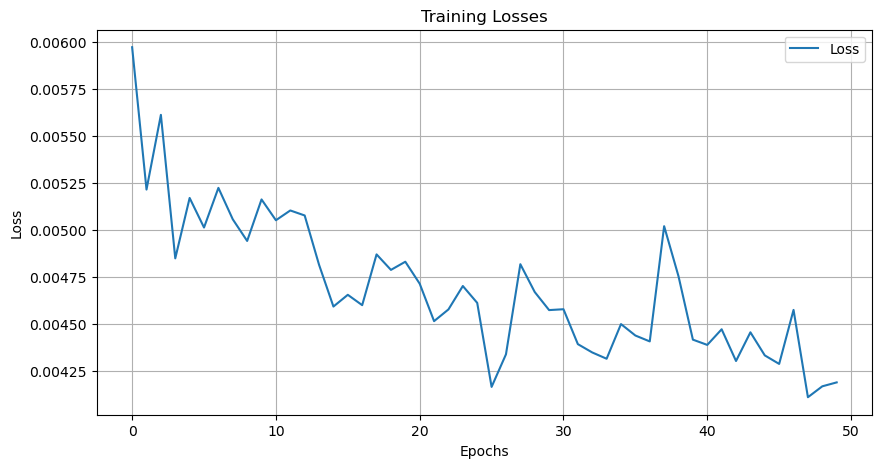

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [15]:
test_data[0][0].shape

torch.Size([1, 28, 28])

In [43]:
torch.save(model.state_dict(), 'pixelcnn_model.pth')

In [5]:
from IPython.display import Image, display
import torch.distributed
import torch

model = PixelCNN(5, 'cuda').to('cuda')
model.load_state_dict(torch.load('pixelcnn_model.pth'))

batch = 4
pixels = torch.zeros((batch, 1, 28, 28), device='cuda') 
batch, channels, rows, cols = pixels.shape

for row in tqdm.tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            pred = model(pixels)[:, channel, row, col]
            uniform = torch.distributions.Uniform(0, 1)
            pixels[:, channel, row, col] = torch.ceil(pred - uniform.sample(pred.shape).to(pred.device))

def deprocess_image(x):
    x = x
    x = np.stack((x, x, x), axis=-1) 
    x /= 255.0  
    x = np.clip(x, 0, 1).astype("float32")
    return x

for i, pic in enumerate(pixels):
    img = deprocess_image(np.squeeze(pic.cpu().detach().numpy(), axis=0))
    img_tensor = torch.tensor(img).permute(2, 0, 1)
    torchvision.utils.save_image(img_tensor, f'generated_image_{i}.png')

# Display images
display(Image('generated_image_0.png'))
display(Image('generated_image_1.png'))
display(Image('generated_image_2.png'))
display(Image('generated_image_3.png'))

/tmp/ipykernel_178904/1535205939.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pixelcnn_model.pth'))
100%|██████████| 28/28 [00:14<00